## Packages

In [77]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset

To be familiar with the dataset, load the data by running the cell below.

In [79]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('dataset') # you need to change your dataset path

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


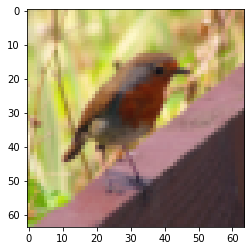

In [80]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [81]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [82]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [83]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [84]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":
    """
    
    np.random.seed(1)
    parameters = {}
    parameters["W1"] = np.random.randn(n_h, n_x)*0.01
    parameters["b1"] = np.zeros((n_h,1))
    parameters["W2"] = np.random.randn(n_y, n_h)*0.01
    parameters["b2"] = np.zeros((n_y,1))

    
    
    return parameters

In [85]:
def sigmoid(Z): return 1/(1+np.exp(-Z))
def relu(Z): return np.maximum(0,Z)

In [86]:

def linear_activation_forward(X,parameters):
    """
    Implement the forward propagation

    Arguments:
    X -- input data:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":

    Returns:
    AL -- output of the forward propogation
    """
    global First_Layer,ReLu_First_Layer,Second_Layer,Sigmoid_Second_Layer

    First_Layer = np.dot(parameters["W1"], X) + parameters["b1"]

    ReLu_First_Layer = relu(First_Layer)

    Second_Layer = np.dot(parameters["W2"], ReLu_First_Layer) + parameters["b2"] 
    Sigmoid_Second_Layer = sigmoid(Second_Layer)

    AL = Sigmoid_Second_Layer
        
    
    return AL

In [87]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    output = np.multiply(np.log(AL),Y) +  np.multiply(np.log(1-AL), (1-Y))
    cost = -1/m*np.sum(output)
    cost = np.squeeze(cost)  
    return cost

In [88]:
def sigmoid_backward(dA, cache): return dA * (1/(1+np.exp(-cache))) * (1-(1/(1+np.exp(-cache))))
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    return dZ

In [89]:
def linear_activation_backward(AL,Y,parameters,X):
    grads = {}

    m = AL.shape[1]

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    dZSigmoid = sigmoid_backward(dAL, Sigmoid_Second_Layer)


    grads["dW2"] = 1./m*np.dot(dZSigmoid, ReLu_First_Layer.T)
    grads["db2"] = 1./m*np.sum(dZSigmoid, axis = 1, keepdims=True)
    dA_prev = np.dot(parameters["W2"].T, dZSigmoid)

  

    dZRelu = relu_backward(dA_prev, First_Layer)

    grads["dW1"] = 1./m*np.dot(dZRelu, X.T)
    grads["db1"] = 1./m*np.sum(dZRelu, axis = 1, keepdims=True)
    dA_prev = np.dot(parameters["W1"].T, dZRelu)


 
    return grads

In [90]:
def update_parameters(parameters, grads, learning_rate):
    for l in range(len(parameters) // 2 ):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    return parameters

In [91]:
def predict(X, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    accuracy = np.zeros((1,m))
    probas = linear_activation_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5: accuracy[0,i] = 1
        else: accuracy[0,i] = 0         
    return accuracy

In [92]:
def plot_loss(costs):
   plt.plot(np.squeeze(costs))
   plt.show()
    

In [93]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000,print_cost=False):
    # keep track of cost
    costs = []
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL = linear_activation_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = linear_activation_backward(AL, Y, parameters, X)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)         
    plot_loss(costs) 
    return parameters

In [94]:
def main():
    parameters = two_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = True)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(predict(train_x, parameters) - train_y)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(predict(test_x, parameters) - test_y)) * 100))

Cost after iteration 0: 0.693050
Cost after iteration 100: 0.646563
Cost after iteration 200: 0.631542
Cost after iteration 300: 0.595537
Cost after iteration 400: 0.542180
Cost after iteration 500: 0.490984
Cost after iteration 600: 0.494087
Cost after iteration 700: 0.402649
Cost after iteration 800: 0.470747
Cost after iteration 900: 0.771026
Cost after iteration 1000: 0.588436
Cost after iteration 1100: 0.680554
Cost after iteration 1200: 0.641188
Cost after iteration 1300: 0.619823
Cost after iteration 1400: 0.573513
Cost after iteration 1500: 0.519131
Cost after iteration 1600: 0.489390
Cost after iteration 1700: 0.416188
Cost after iteration 1800: 0.541169
Cost after iteration 1900: 0.504574
Cost after iteration 2000: 0.604008
Cost after iteration 2100: 0.520753
Cost after iteration 2200: 0.633037
Cost after iteration 2300: 0.614661
Cost after iteration 2400: 0.592630
Cost after iteration 2500: 0.569813
Cost after iteration 2600: 0.539021
Cost after iteration 2700: 0.508496
Cost

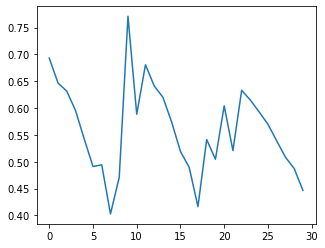

train accuracy: 87.5598086124402 %
test accuracy: 56.0 %


In [95]:
main()